# LinkNet: нейронная сеть для семантической сегментации изображений

Abhishek Chaurasia, Eugenio Culurciello, Jun 2017, https://arxiv.org/abs/1707.03718

Воспользуемся LinkNet для сегментации изображений $128 \times 128$, в которых в случайном месте располагается изображение MNIST $28 \times 28$ и добавлен шум из обрезков других картинок из базы.

In [1]:
import sys
import os
import numpy as np
import tensorflow as tf
from time import time

import matplotlib.pyplot as plt

sys.path.append(os.path.join('..','..'))

from az_training.dataset import Dataset, DatasetIndex
from az_training.task_02.linknet import LinkNetBatch
from az_training.task_02.plot_functions import plot_example_interactive, plot_examples

%matplotlib inline

In [2]:
MNIST_SIZE = 65000
BATCH_SIZE = 512
MAX_ITER = 200

In [3]:
# создадим индекс и датасет для построения пайплайна

ind = DatasetIndex(np.arange(MNIST_SIZE))
mnistset = Dataset(ind, batch_class=LinkNetBatch)
mnistset.cv_split([0.9, 0.1])

In [4]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

In [5]:
prediction = []
test_loss = []
train_loss = []

In [6]:
# пайплайны для обучения и контроля

level = 1
n_fragments = 100
size = 10
distr = 'uniform'

ppl = mnistset.train.pipeline()\
        .load_images()\
        .random_location() \
        .create_mask()\
        .add_noise('mnist_noise', level, n_fragments, size, distr)\
        .train(sess)\
        .get_stat(sess, train_loss, True)\
        
ppl_test = mnistset.test.pipeline()\
            .load_images()\
            .random_location() \
            .create_mask()\
            .add_noise('mnist_noise', level, n_fragments, size, distr)

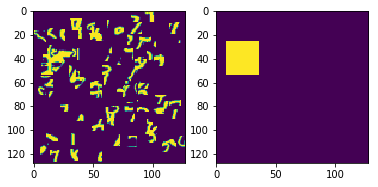

In [7]:
images = []
masks = []
ppl_test.get_images(images, masks).next_batch(100, n_epochs=None)
plt.subplot(121)
plt.imshow(images[0][0])
plt.subplot(122)
plt.imshow(masks[0][0])
plt.show()

In [8]:
# обучение

start = time()
for i in range(MAX_ITER):
    ppl.next_batch(BATCH_SIZE, n_epochs=None)
    ppl_test.get_stat(sess, test_loss, False).next_batch(100, n_epochs=None)
    if (i+1) % 10 == 0:
        print("Iter {:3d}: train {:05.3f} test {:05.3f}".format(i+1, 
                                                                train_loss[-1], 
                                                                test_loss[-1]))
stop = time()
print("Train time: {:05.3f} min".format((stop-start)/60))

Iter  10: train 0.537 test 0.610
Iter  20: train 0.425 test 0.403
Iter  30: train 0.347 test 0.338
Iter  40: train 0.281 test 0.280
Iter  50: train 0.235 test 0.230
Iter  60: train 0.194 test 0.199
Iter  70: train 0.166 test 0.172
Iter  80: train 0.143 test 0.144
Iter  90: train 0.125 test 0.126
Iter 100: train 0.112 test 0.105
Iter 110: train 0.102 test 0.100
Iter 120: train 0.093 test 0.090
Iter 130: train 0.084 test 0.083
Iter 140: train 0.078 test 0.086
Iter 150: train 0.073 test 0.080
Iter 160: train 0.071 test 0.074
Iter 170: train 0.072 test 0.063
Iter 180: train 0.062 test 0.061
Iter 190: train 0.062 test 0.062
Iter 200: train 0.060 test 0.063
Train time: 23.661 min


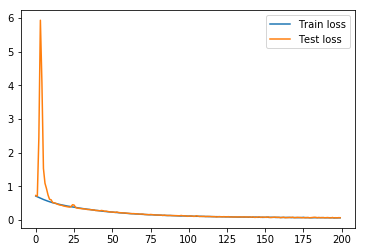

In [9]:
plt1, = plt.plot(train_loss,  label='Train loss')
plt2, = plt.plot(test_loss, label='Test loss')
plt.legend(handles=[plt1, plt2])
plt.show()

In [10]:
prediction = []
images = []
masks = []
ppl_test.get_images(images, masks)\
        .predict_proba(sess, prediction).next_batch(10, n_epochs=None)

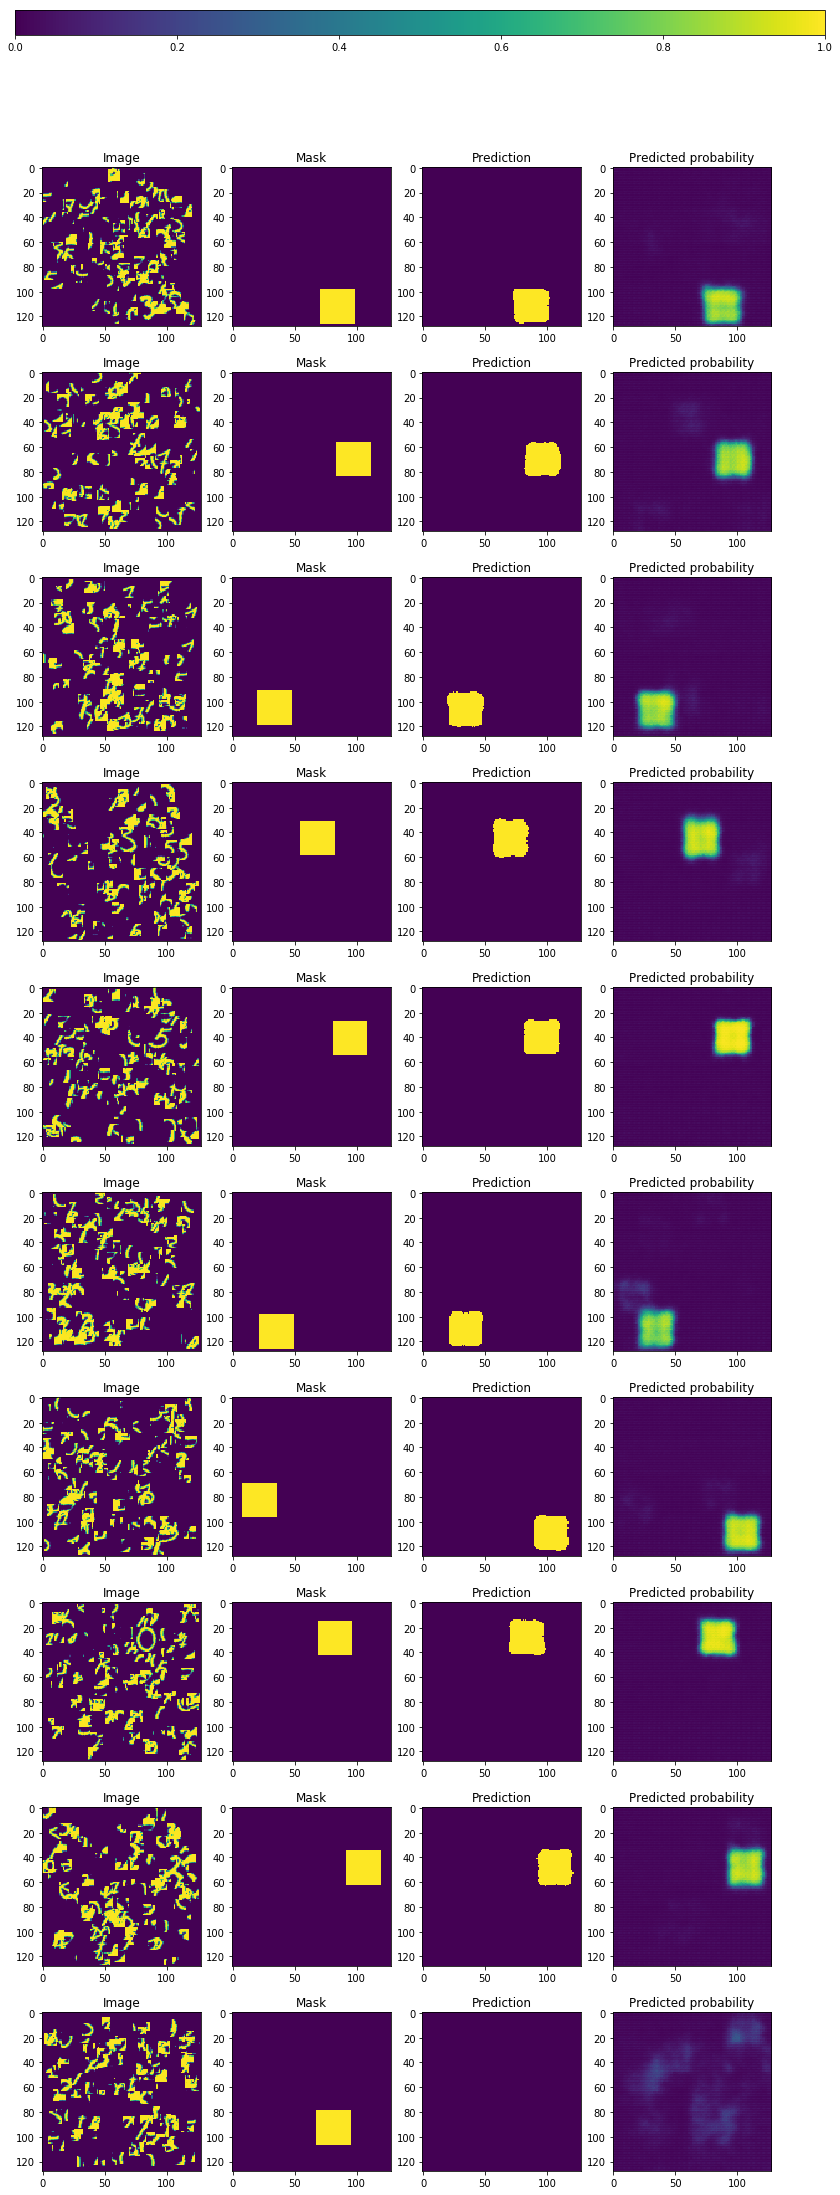

In [11]:
plot_examples(images, masks, prediction)